Memory Coalescing
=================
In this part we will talk about memory coalescence. We will talk about what it
is and why it is important. We will also showcase a program, where we will see
how it should be done and how it should not be done.

0 What is it?
-------------
On a GPU we have three layers of memory:
- Global
- Shared
- Local (registers)

When we access global memory on a gpu, we access multiple elements at the same
time. This is important to keep in mind, when programming, because access to
global memory is slow. So we need to utilise that we are accessing multiple
elements at the same time. Therefore we need adjacent threads on the GPU to
access adjacent memory in order to gain maximum performance.

1 Matrix addition
-----------------
We will be looking at matrix addition, but for teaching purposes we will only
parallelise one dimension. We will show the differences in parallelising each
dimension and describe why there is a difference. It is important to note
that in this example we use a row major memory layout.

2 Parallelising the outer loop
------------------------------
When programming a CPU the correct thing to do would be to parallelise the outer
loop, because we would then get cache coherency. So this is what we have done in
the first part. This is not optimal on a GPU, because when we access memory, we
get multiple elements at the same time as described earlier. When parallelising
the outer loop, every thread in the thread block will read their section of
memory, which requires multiple reads of global memory.

![Every thread will read from a different block of memory](notcoalesced.png)

In [1]:
import numpy as np
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import math
import time

mod = SourceModule("""
        __global__ void matrixaddition(
            const int *a,
            const int *b,
            int *res,
            ushort width,
            ushort height)
        {
            int i = blockIdx.x*blockDim.x+threadIdx.x;

            if (i < height) {
                for (int j = 0; j < width; j++) {
                    res[i*width+j] = a[i*width+j]+b[i*width+j];
                }
            }
        }
        """)

width = 10000
height = 10000

a = np.ones((height, width)).astype(np.int32)
b = np.ones((height, width)).astype(np.int32)

res = np.empty((height, width)).astype(np.int32)

dim_size = 1024
block_size = (dim_size,1,1)
grid_size = (int(math.ceil(height / float(dim_size))),1)

start_time = time.time()
matrixaddition = mod.get_function("matrixaddition")
matrixaddition(
        cuda.In(a),
        cuda.In(b),
        cuda.Out(res),
        np.uint16(width),
        np.uint16(height),
        block=block_size,
        grid=grid_size)
total_time_outer = time.time() - start_time

print(res)

[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]


3 Parallelising the inner loop
------------------------------
To fix the error in the previous version, we instead parallelise the inner loop.
This means when we are reading data from global memory, then every data point is
given to a thread and no data is fetched without being assigned to a thread. It is also important to note                                                           
 25 that in this example we use a row major memory layout.

![All threads read within the same block of memory](coalesced.png)


In [2]:
import numpy as np
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import math
import time

mod = SourceModule("""
        __global__ void matrixaddition(
            const int *a,
            const int *b,
            int *res,
            ushort width,
            ushort height)
        {
            int i = blockIdx.x*blockDim.x+threadIdx.x;

            if (i < width) {
                for (int j = 0; j < height; j++) {
                    res[j*width+i] = a[j*width+i]+b[j*width+i];
                }
            }
        }
        """)

width = 10000
height = 10000

a = np.ones((height, width)).astype(np.int32)
b = np.ones((height, width)).astype(np.int32)

res = np.empty((height, width)).astype(np.int32)

dim_size = 512
block_size = (dim_size,1,1)
grid_size = (int(math.ceil(width / float(dim_size))),1)

start_time = time.time()
matrixaddition = mod.get_function("matrixaddition")
matrixaddition(
        cuda.In(a),
        cuda.In(b),
        cuda.Out(res),
        np.uint16(width),
        np.uint16(height),
        block=block_size,
        grid=grid_size)
total_time_inner = time.time() - start_time

print(res)

[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]


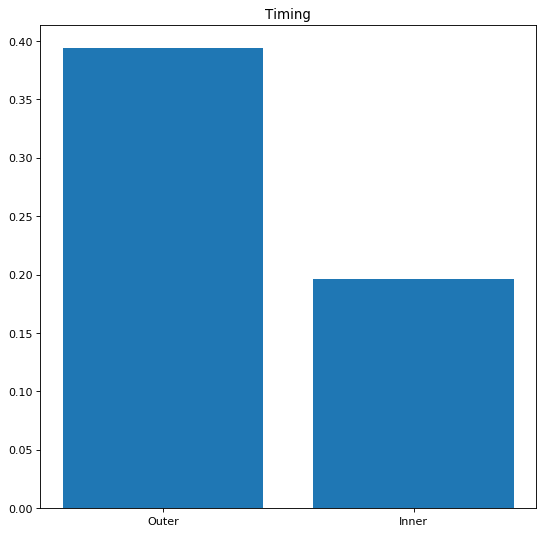

In [4]:
import matplotlib.pyplot as plt
names = ["Outer", "Inner"]
values = [total_time_outer, total_time_inner]

fig=plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.title("Timing")
plt.bar(names, values)

plt.show()